## 範例重點
* 了解如何在 Keras 中，加入 regularization
* 熟悉建立、訓練模型
* 熟悉將訓練結果視覺化並比較結果

In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W0724 09:06:57.492365 4699448768 deprecation_wrapper.py:119] From /Users/pmpmpm/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0724 09:06:57.494349 4699448768 deprecation_wrapper.py:119] From /Users/pmpmpm/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0724 09:06:57.520975 4699448768 deprecation_wrapper.py:119] From /Users/pmpmpm/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 09:06:57.524528 4699448768 deprecation_wrapper.py:119] From /Users/pmpmpm/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.comp

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0724 09:06:57.877200 4699448768 deprecation.py:323] From /Users/pmpmpm/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 154us/step - loss: 15.0895 - acc: 0.2658 - val_loss: 13.9571 - val_acc: 0.3310
Epoch 2/50
50000/50000 [==============================] - 6s 123us/step - loss: 13.0201 - acc: 0.3464 - val_loss: 12.1306 - val_acc: 0.3613
Epoch 3/50
50000/50000 [==============================] - 6s 119us/step - loss: 11.3471 - acc: 0.3736 - val_loss: 10.5905 - val_acc: 0.3869
Epoch 4/50
50000/50000 [==============================] - 6s 122us/step - loss: 9.9343 - acc: 0.3889 - val_loss: 9.2996 - val_acc: 0.3926
Epoch 5/50
50000/50000 [==============================] - 7s 136us/step - loss: 8.7330 - acc: 0.4002 - val_loss: 8.1932 - val_acc: 0.4056
Epoch 6/50
50000/50000 [==============================] - 5s 109us/step - loss: 7.7091 - acc: 0.4121 - val_loss: 7.2456 - val_acc: 0.4122
Epoch 7/50
50000/50000 [==============================] - 6s 116us/step - loss: 6.8352 - acc: 0.4179 - val_loss: 6.4

50000/50000 [==============================] - 11s 225us/step - loss: 2.1499 - acc: 0.2847 - val_loss: 1.9926 - val_acc: 0.3473
Epoch 2/50
50000/50000 [==============================] - 10s 209us/step - loss: 1.9390 - acc: 0.3698 - val_loss: 1.8961 - val_acc: 0.3813
Epoch 3/50
50000/50000 [==============================] - 11s 211us/step - loss: 1.8546 - acc: 0.3986 - val_loss: 1.8243 - val_acc: 0.4129
Epoch 4/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.7953 - acc: 0.4199 - val_loss: 1.8003 - val_acc: 0.4132
Epoch 5/50
50000/50000 [==============================] - 11s 211us/step - loss: 1.7503 - acc: 0.4366 - val_loss: 1.7400 - val_acc: 0.4338
Epoch 6/50
50000/50000 [==============================] - 11s 211us/step - loss: 1.7118 - acc: 0.4484 - val_loss: 1.7043 - val_acc: 0.4520
Epoch 7/50
50000/50000 [==============================] - 11s 212us/step - loss: 1.6775 - acc: 0.4596 - val_loss: 1.6916 - val_acc: 0.4532
Epoch 8/50
50000/50000 [==============

Epoch 2/50
50000/50000 [==============================] - 10s 207us/step - loss: 1.8129 - acc: 0.3625 - val_loss: 1.7719 - val_acc: 0.3736
Epoch 3/50
50000/50000 [==============================] - 10s 206us/step - loss: 1.7303 - acc: 0.3945 - val_loss: 1.6998 - val_acc: 0.4069
Epoch 4/50
50000/50000 [==============================] - 10s 208us/step - loss: 1.6686 - acc: 0.4144 - val_loss: 1.6517 - val_acc: 0.4199
Epoch 5/50
50000/50000 [==============================] - 10s 206us/step - loss: 1.6196 - acc: 0.4343 - val_loss: 1.6057 - val_acc: 0.4348
Epoch 6/50
50000/50000 [==============================] - 10s 209us/step - loss: 1.5799 - acc: 0.4480 - val_loss: 1.5714 - val_acc: 0.4462
Epoch 7/50
50000/50000 [==============================] - 10s 205us/step - loss: 1.5441 - acc: 0.4609 - val_loss: 1.5439 - val_acc: 0.4524
Epoch 8/50
50000/50000 [==============================] - 10s 204us/step - loss: 1.5132 - acc: 0.4684 - val_loss: 1.5222 - val_acc: 0.4654
Epoch 9/50
50000/50000 [===

50000/50000 [==============================] - 11s 221us/step - loss: 1.8029 - acc: 0.3670 - val_loss: 1.7542 - val_acc: 0.3870
Epoch 3/50
50000/50000 [==============================] - 10s 209us/step - loss: 1.7236 - acc: 0.3968 - val_loss: 1.6950 - val_acc: 0.4002
Epoch 4/50
50000/50000 [==============================] - 10s 206us/step - loss: 1.6670 - acc: 0.4149 - val_loss: 1.6474 - val_acc: 0.4206
Epoch 5/50
50000/50000 [==============================] - 10s 205us/step - loss: 1.6217 - acc: 0.4299 - val_loss: 1.6267 - val_acc: 0.4270
Epoch 6/50
50000/50000 [==============================] - 10s 205us/step - loss: 1.5836 - acc: 0.4445 - val_loss: 1.5791 - val_acc: 0.4420
Epoch 7/50
50000/50000 [==============================] - 12s 230us/step - loss: 1.5475 - acc: 0.4562 - val_loss: 1.5471 - val_acc: 0.4514
Epoch 8/50
50000/50000 [==============================] - 10s 208us/step - loss: 1.5161 - acc: 0.4691 - val_loss: 1.5251 - val_acc: 0.4603
Epoch 9/50
50000/50000 [==============

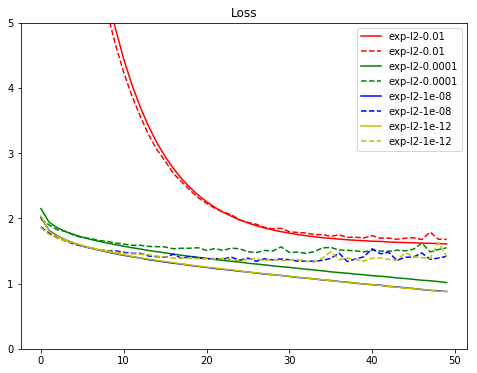

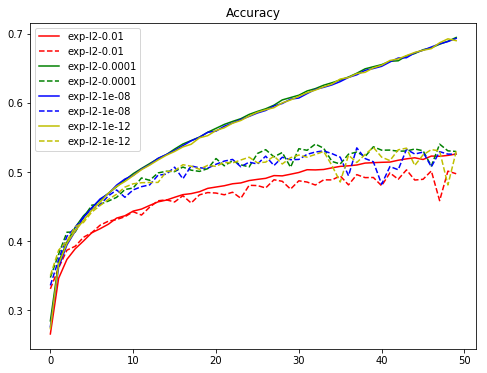

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果